# Computer Vision II



## Lecture U1-02:   Optical Flow  Lab notebook 
David Olivieri, Uvigo


### Brief outline

In this lab we will explore some algorithms of optical flow.  The idea is to gain some intuition about the basic algorithms and the functioning (not the technical details) of some advanced routines in OpenCV (for optical flow).  In particular, the notebook contains the following sections: 

1. Fundamental algorithms:   The Horn-Schunck and Lucas-Kanade algorithms

2. OpenCV routines:   Farneback,  Lucas-Kanade Pyramid, calcOpticalFlowSparseToDense,  RLOF algorithm

3. An application of optical flow:  classification of actions



# 1.  Fundamental Algorithms


As we saw in class, the Horn-Schunck and Lucas-Kanade Optical Flow methods are the some of the most widely used techniques.   Here, we will studyh the implementation of these methods in python in order to elucidate the steps of each algorithm as they are given in class.  Note that: 
- these algorithms are not optimized for speed and are only for illustrative purposes. 
- these routines are not available in the latest version of OpenCV  (prior to ver3.0, the routines are available:  CalcOpticalFlowBM, CalcOpticalFlowHS, CalcOpticalFlowLK)



##  1.A  Horn-Schunck

Here is an implementation in a function so that you can study the steps of the algorithm.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Some useful utilities

In [2]:
def get_magnitude(u, v):
    # Compute the magnitude of the flow
    dy = v * 3
    dx = u * 3
    magnitude = np.sqrt(dx**2 + dy**2)
    # Compute the average magnitude
    step_size = max(int(np.sqrt(u.size) / 100), 1)  # dynamic step size
    mag_avg = np.mean(magnitude[::step_size, ::step_size])

    return mag_avg
    
def draw_quiver(u, v, beforeImg):
    scale = 3
    # Compute the magnitude of the flow
    dy = v * scale
    dx = u * scale
    magnitude = np.sqrt(dx**2 + dy**2)

    # Compute the average magnitude
    magnitude_avg = get_magnitude(u, v)

    # Compute the arrow positions and directions
    step_size = max(int(np.sqrt(u.size) / 100), 1)  # dynamic step size
    y, x = np.mgrid[step_size // 2:u.shape[0]:step_size, step_size // 2:u.shape[1]:step_size]
    dy = v[::step_size, ::step_size] * scale
    dx = u[::step_size, ::step_size] * scale

    # Filter the arrows by magnitude
    mask = magnitude[::step_size, ::step_size] > magnitude_avg
    x, y, dx, dy = x[mask], y[mask], dx[mask], dy[mask]

    # Draw the vector field
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap='gray')
    ax.quiver(x, y, dx, dy, color='red', angles='xy', scale_units='xy', scale=1)
    plt.draw()
    plt.show()

In [3]:
def horn_schunck_optical_flow(image1, image2, alpha, iterations):
    # Precompute image gradients Ix and Iy
    Ix = cv2.Sobel(image1, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(image1, cv2.CV_64F, 0, 1, ksize=3)

    # Precompute the temporal gradient It
    It = image2 - image1

    # Initialize the flow fields: u = 0, v = 0
    u = np.zeros_like(image1, dtype=np.float64)
    v = np.zeros_like(image1, dtype=np.float64)

    # Define a function to compute the average of neighboring pixels
    def average_neighborhood(img):
        kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                           [1 / 6, 0, 1 / 6],
                           [1 / 12, 1 / 6, 1 / 12]])
        return cv2.filter2D(img, -1, kernel)

    # Iterate until convergence or maximum iterations
    for _ in range(iterations):
        u_avg = average_neighborhood(u)
        v_avg = average_neighborhood(v)

        # Compute flow field updates for each pixel
        numerator = (Ix * u_avg + Iy * v_avg + It)
        denominator = (alpha ** 2 + Ix ** 2 + Iy ** 2)
        u_new = u_avg - Ix * numerator / denominator
        v_new = v_avg - Iy * numerator / denominator

        # Update flow fields
        u, v = u_new, v_new

    return u, v

### Images for testing out the above
We will use some different images here to test this out.

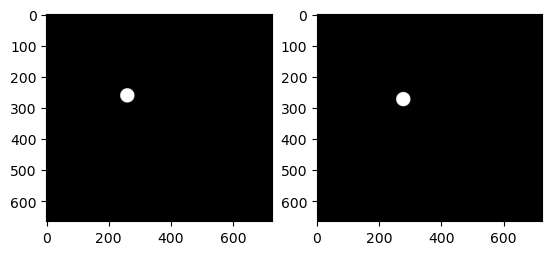

In [4]:
image1 = cv2.imread("./tstimgs/image1.png", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("./tstimgs/image2.png", cv2.IMREAD_GRAYSCALE)


fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

## could use nearest (note, bilinear is smoothed)
ax1.imshow(image1, interpolation='bilinear', cmap=cm.Greys_r)
ax2.imshow(image2, interpolation='bilinear', cmap=cm.Greys_r)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.show()

### Running the algorithm

In [5]:
alpha = 1.0
iterations = 100
u, v = horn_schunck_optical_flow(image1, image2, alpha, iterations)

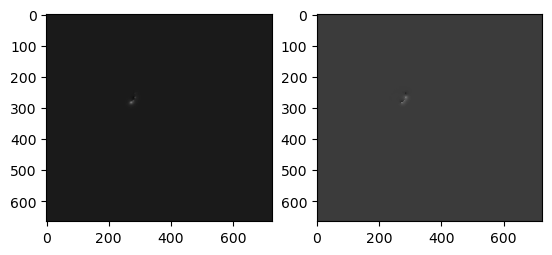

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(u, interpolation='bilinear', cmap=cm.Greys_r)
ax2.imshow(v, interpolation='nearest', cmap=cm.Greys_r)
plt.show()

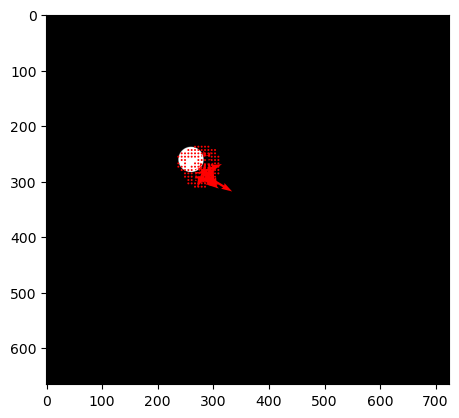

In [7]:
draw_quiver(u, v, image1)


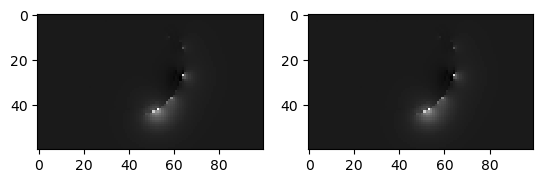

In [8]:
urect = u[240:300, 220:320]
vrect = u[240:300, 220:320]
#print(urect)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(urect, interpolation='nearest', cmap=cm.Greys_r)
ax2.imshow(vrect, interpolation='nearest', cmap=cm.Greys_r)
plt.show()

###  Suggested exercise (not to be submitted): Test your understanding

1.  Do the results make sense?  If you look at the small region where the point in the image is changing, could you calculate what the derivative should be?  Vary the parameters (alpha, iterations) and see how they affect the output. You can also try using different neighborhood averaging kernels to see their effect on the results.

2.  Try the same with large displacements. Several images in the test image directory are available for different tests.  

3.  Implement a method to visualize the flow vectors using a color-coded image, where each pixel color represents the direction and magnitude of the flow.

4. Apply the optical flow algorithm to a real-world video sequence and visualize the results using a quiver or color-coded flow image.

5. Modify the algorithm to handle noisy images by adding a regularization term to the numerator and denominator in the update equation.


## 1.B Lucas-Kanade

From class, the python code is the following.  Here you can see how this implements the algorithm described.

###  Recall the mathematics of the Lucas-Kanade method

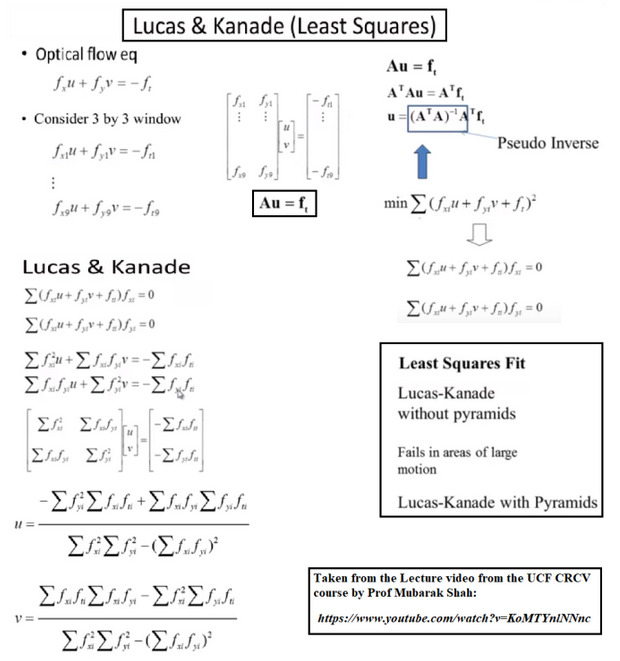

In [9]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [10]:
def get_magnitude(u, v):
    # Compute the magnitude of the flow
    dy = v * 3
    dx = u * 3
    magnitude = np.sqrt(dx**2 + dy**2)
    # Compute the average magnitude
    step_size = max(int(np.sqrt(u.size) / 100), 1)  # dynamic step size
    mag_avg = np.mean(magnitude[::step_size, ::step_size])

    return mag_avg
    
def draw_quiver(u, v, beforeImg):
    scale = 3
    # Compute the magnitude of the flow
    dy = v * scale
    dx = u * scale
    magnitude = np.sqrt(dx**2 + dy**2)

    # Compute the average magnitude
    magnitude_avg = get_magnitude(u, v)

    # Compute the arrow positions and directions
    step_size = max(int(np.sqrt(u.size) / 100), 1)  # dynamic step size
    y, x = np.mgrid[step_size // 2:u.shape[0]:step_size, step_size // 2:u.shape[1]:step_size]
    dy = v[::step_size, ::step_size] * scale
    dx = u[::step_size, ::step_size] * scale

    # Filter the arrows by magnitude
    mask = magnitude[::step_size, ::step_size] > magnitude_avg
    x, y, dx, dy = x[mask], y[mask], dx[mask], dy[mask]

    # Draw the vector field
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap='gray')
    ax.quiver(x, y, dx, dy, color='red', angles='xy', scale_units='xy', scale=1)
    plt.draw()
    plt.show()

In [11]:
import numpy as np
from scipy import signal


def lucas_kanade_optical_flow(I1g, I2g, window_size, tau=1e-2):
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    w = int(window_size/2.) 
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    nu= np.zeros(I1g.shape)
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()

            # if threshold τ is larger than the smallest eigenvalue of A'A:
            b = np.reshape(It, (It.shape[0],1)) # get b here
            A = np.vstack((Ix, Iy)).T # get A here

            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
                u[i,j]=nu[0]
                v[i,j]=nu[1]            

    return (u,v)

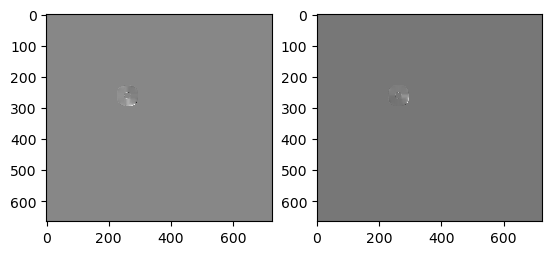

In [12]:
image1 = cv2.imread("./tstimgs/image1.png", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("./tstimgs/image3.png", cv2.IMREAD_GRAYSCALE)

image1.shape[1]

window_size = 21
u, v = lucas_kanade_optical_flow(image1, image2, window_size, tau=1e-2)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(u, interpolation='nearest', cmap=cm.Greys_r)
ax2.imshow(v, interpolation='nearest', cmap=cm.Greys_r)
plt.show()

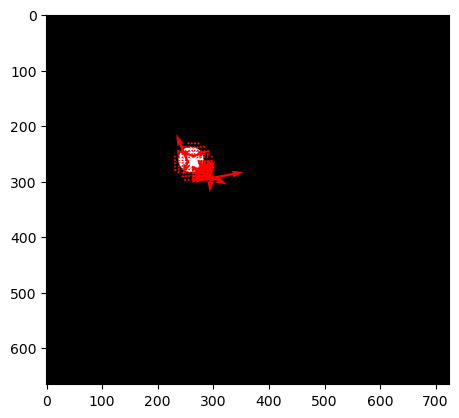

In [13]:
draw_quiver(u, v, image1)

###  Suggested exercise (not to be submitted): Test your understanding

1.  How does this depend on whether the image has edges or is smooth? How does the above depend upon the size of the window?  Vary the window size and the threshold (tau) and see how they affect the output. You can also try using different convolution kernels to see their effect on the results. 
2.  How do large displacements affect the algorithm?  Try the above with different images provided in the directory.
3. Implement a method to visualize the flow vectors using a color-coded image, where each pixel color represents the direction and magnitude of the flow.
4.  There are lots of ways to improve this algorithm and make it faster.  Here are some suggestions that could be used to re-implement the algorithm: 

- Precompute the A'A matrix: Instead of computing A'A for each point, you can precompute the elements of A'A for the entire image and then use these elements to compute the eigenvalues.

- Update kernel_t: You can combine the two convolutions for ft into a single convolution with a kernel ``kernel_t = np.array([[1., 1.], [1., 1.]]) * 0.25.`` This change simplifies the calculations.

- Use convolution to calculate the sum of the products within the window: Instead of using nested loops to compute the sum of the products.  This would gain considerably more speed.


# 2.  Implementation with OpenCV

## 2.A   Farneback algorithm

The main idea of this method is to approximate some neighbors of each pixel with a polynomial: 
$I(x) \sim x^T \! Ax + b^T \! x+c$. Generally speaking, in the Lucas-Canade method we used the linear approximation $I = b^Tx + c$ since we had only first-order Taylor’s expansion. Now, we are increasing the accuracy of approximation with second-order values. Here, the idea leads to observing the differences in the approximated polynomials caused by object displacements. Our goal here is to calculate a displacement $d$ in the $I_2(x)=I_1(x-d)$ equation using the polynomial approximation.

The additional information about the algorithm and it’s improvements you can find in the original paper.
https://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf


#### Implementation:
The OpenCV Farneback algorithm requires a 1-dimensional input image, so we convert the BRG image into gray-scale. Lucas-Kanade method computes optical flow for a sparse feature set (in our example, corners detected using Shi-Tomasi algorithm). OpenCV provides another algorithm to find the dense optical flow. It computes the optical flow for all the points in the frame. It is based on Gunnar Farneback's algorithm which is explained in "Two-Frame Motion Estimation Based on Polynomial Expansion" by Gunnar Farneback in 2003.


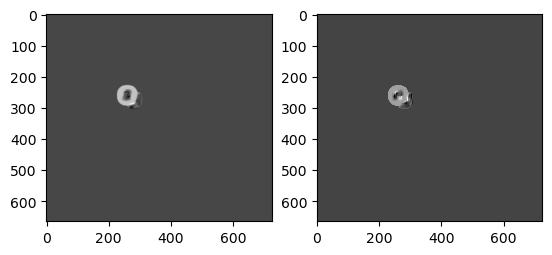

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
frame1 = cv2.imread('./tstimgs/image1.png')
frame2 = cv2.imread('./tstimgs/image2.png')

gray1 = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

flow = np.zeros_like(gray1)
flow = cv2.calcOpticalFlowFarneback(gray1, gray2, flow,pyr_scale=0.5, levels=3, winsize=15,iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

# Change here
horz = cv2.normalize(flow[...,0], None, 0, 255, cv2.NORM_MINMAX)     
vert = cv2.normalize(flow[...,1], None, 0, 255, cv2.NORM_MINMAX)
horz = horz.astype('uint8')
vert = vert.astype('uint8')

# Change here too
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(horz, interpolation='bilinear', cmap=cm.Greys_r)
ax2.imshow(vert, interpolation='nearest', cmap=cm.Greys_r)
plt.show()




###  Suggested exercise (not to be submitted): Test your understanding

1.  How does the above depend upon the input parameters of calcOpticalFlowFarneback?
2.  How do large displacements affect the algorithm?  You could use the svg in the tstimg directory in order to make other objects with corners. 
3.  Use the quiver plot to observe the vedctors $(u,v)$ from the flow.  


###  Using a video example

In [15]:
import numpy as np
import cv2 as cv
cap = cv.VideoCapture(cv.samples.findFile("./tstvideos/vtest.avi"))
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
while(1):
    ret, frame2 = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    cv.imshow('frame2', bgr)
    
    ## Break with the ESC key.
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv.imwrite('opticalfb.png', frame2)
        cv.imwrite('opticalhsv.png', bgr)
    prvs = next
cv.destroyAllWindows()

You should see the following results: 

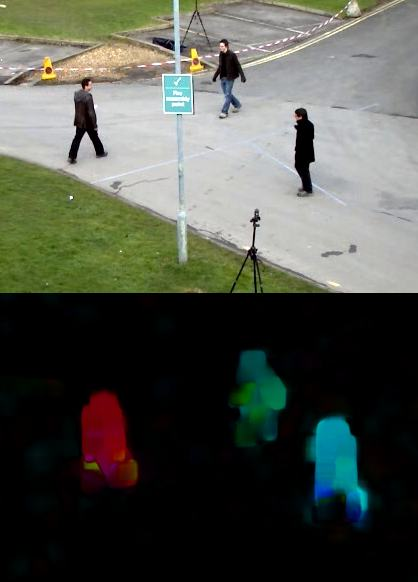

###  Suggested exercise (not to be submitted): Test your understanding

1.  How does the above depend upon the input parameters of calcOpticalFlowFarneback?  Test the above with different values of the window size and pyramid parameters.


## 2.B  Dense optical flow with Pyramids / Features


- the Lucas-Kanade algorithm requires a set of features to track in order to estimate the optical flow between frames.

- The Lucas-Kanade algorithm estimates the motion of features between two frames of a video by assuming that the motion of the features is constant within a local neighborhood of each feature point. The algorithm then solves a system of linear equations to estimate the motion of the features based on the brightness changes in the local neighborhood over time.

- In order to use the Lucas-Kanade algorithm, you need to specify a set of feature points in the first frame of the video to track. These feature points can be detected using a feature detection algorithm such as Harris corner detection or Shi-Tomasi corner detection, or you can manually select the feature points.

- Once you have selected the feature points, you can use the Lucas-Kanade algorithm to estimate the motion of the features between each pair of frames in the video. However, it is important to note that the Lucas-Kanade algorithm can only estimate the motion of the features that were present in the first frame of the video. If the scene contains new features or if the tracked features move out of the frame, the algorithm will not be able to track them.


##  Idea of pyramid:

#### From book by Szeliski: 


To accelerate this search process, hierarchical motion estimation is often used: an image pyramid
(Section 3.5) is constructed and a search over a smaller number of discrete pixels (corresponding to
the same range of motion) is first performed at coarser levels (Quam 1984; Anandan 1989; Bergen,
Anandan et al. 1992). The motion estimate from one level of the pyramid is then used to initialize
a smaller local search at the next finer level. Alternatively, several seeds (good solutions) from the
coarse level can be used to initialize the fine-level search. While this is not guaranteed to produce
the same result as a full search, it usually works almost as well and is much faster.



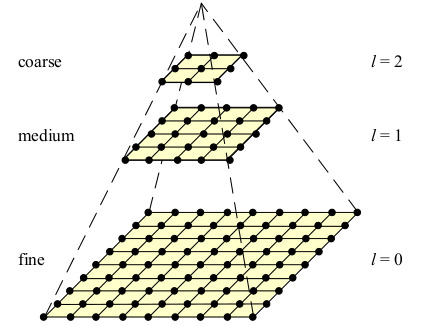

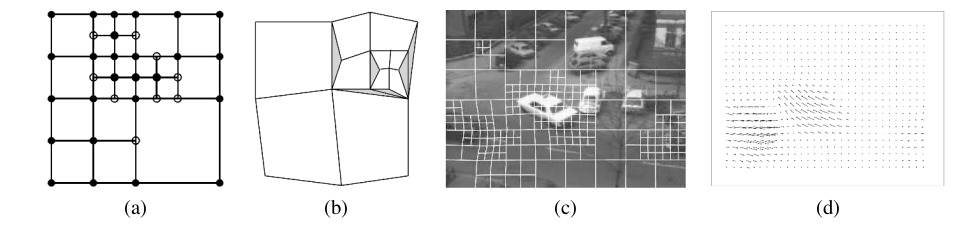

### Dense Pyramid for Lucas-Kanade Method


OpenCV provides all these in a single function, ``calcOpticalFlowPyrLK()``. Here, we create a simple application which tracks some points in a video. To decide the points, we use ``goodFeaturesToTrack()``. We take the first frame, detect some Shi-Tomasi corner points in it, then we iteratively track those points using Lucas-Kanade optical flow. For the function ``calcOpticalFlowPyrLK()`` we pass the previous frame, previous points and next frame. It returns next points along with some status numbers which has a value of 1 if next point is found, else zero. We iteratively pass these next points as previous points in next step. 

In [16]:
import numpy as np 
import cv2 as cv
import argparse

# Initialize video capture
cap = cv.VideoCapture('./tstvideos/cars.mp4')

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )


# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0, 255, (100, 3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv.add(frame, mask)
    cv.imshow('frame', img)
    
    
    # Press ESC to exit.
    
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

# Release video capture and close windows
cap.release()
cv.destroyAllWindows()

###  Suggested exercise (not to be submitted): Test your understanding

1.  How does the above depend upon the input parameters of calcOpticalFlowPyrLK?  What about the features to track? Test the above with different values of the window size and pyramid parameters.
2.  What happens when the original features of the first frame are no longer in the subsequent frames?  Try and think about how to modify the algorithm so that when new features appear they are used for obtaining the optical flow. 

### 2.C More dense optical flow algorithms

There are several other routines within the ```optflow``` .  Here, we only mention two:
- cv2.optflow.calcOpticalFlowSparseToDense
- cv2.optflow.calcOpticalFlowDenseRLOF


### A note on visualizing results

The dense optical flow algorithm output can be encoded as the HSV color scheme. Using the cv2.cartToPolar function, we can convert the displacement coordinates (dx, dy) into polar coordinates as magnitude and angle for every pixel. Here we can encode angle and magnitude as Hue and Value respectively, while Saturation remains constant. To show the optical flow properly, we need to convert the HSV into BGR format.


###  Example of cv2.optflow.calcOpticalFlowSparseToDense

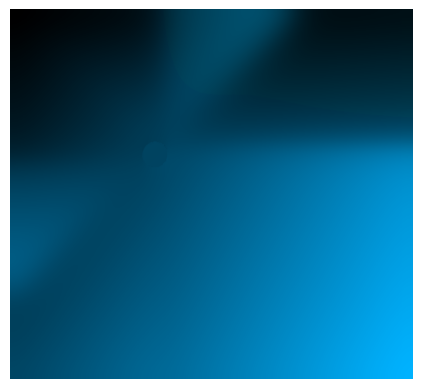

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load two consecutive frames from a video


frame1 = cv2.imread('./tstimgs/image1.png')
frame2 = cv2.imread('./tstimgs/image3.png')


if len(frame1.shape) == 3:
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
else:
    gray1 = frame1

if len(frame2.shape) == 3:
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
else:
    gray2 = frame2


# Calculate dense optical flow using cv2.optflow.calcOpticalFlowSparseToDense() routine
flow = cv2.optflow.calcOpticalFlowSparseToDense(gray1, gray2, None)
# Split the flow vectors into separate u and v components
u, v = cv2.split(flow)


# Convert the flow to an RGB image for display
h, w = gray1.shape[:2]
hsv = np.zeros((h, w, 3), dtype=np.uint8)
hsv[..., 1] = 255
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
if np.var(mag) > 1e-6:
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
plt.imshow(rgb)
plt.axis('off')
plt.show()

###  The  RLOF  Optical Flow algorithm

The RLOF algorithm is based on an illumination model proposed by Gennert and Negahdaripour in 1995: $I(x,y,t) + m \cdot I(x,y,t) + c = I(x + u, y + v, t + 1)$, where $m, c$ are the illumination model parameters. Like in the previous algorithms, there is a local motion constancy assumption supplemented with illumination constancy. Mathematically, it means that the vector $[d\;m\;c]$ is constant for every local image region.

The authors define the minimization function based on the illumination model and optimization method that works iteratively until the convergence. The optimization process is described in the original paper. https://ieeexplore.ieee.org/document/6209407


### Example with cv2.optflow.calcOpticalFlowDenseRLOF
RLOF algorithm, in contrast to Farneback, requires the 3-channel image, so there is no preprocessing here. Now our method has changed to cv2.optflow.calcOpticalFlowDenseRLOF:

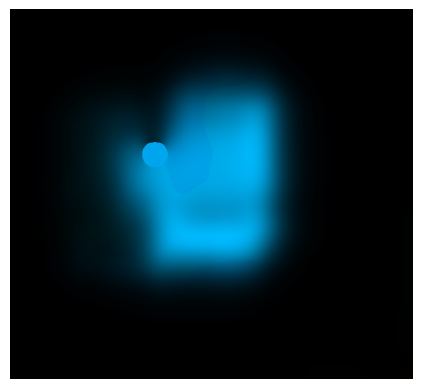

In [18]:
#!/usr/bin/env python

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load two consecutive frames from a video


frame1 = cv2.imread('./tstimgs/image1.png')
frame2 = cv2.imread('./tstimgs/image3.png')

if len(frame1.shape) == 3:
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
else:
    gray1 = frame1

if len(frame2.shape) == 3:
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
else:
    gray2 = frame2
    
    
rlof_param = cv2.optflow.RLOFOpticalFlowParameter_create()
# Pre-allocate an empty numpy array for the flow
h, w = frame1.shape[:2]
flow = np.zeros((h, w, 2), dtype=np.float32)

# Compute dense optical flow using cv2.optflow.calcOpticalFlowDenseRLOF() routine
cv2.optflow.calcOpticalFlowDenseRLOF(frame1, frame2, flow, rlof_param)
# Convert the flow to an RGB image for display
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros((h, w, 3), dtype=np.uint8)
hsv[..., 1] = 255
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])


if np.var(mag) > 1e-6:
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Display the optical flow image using matplotlib.pyplot.imshow()
plt.imshow(rgb)
plt.axis('off')
plt.show()

###  Suggested exercise (not to be submitted): Test your understanding

1.  How does the above depend upon the input parameters of calcOpticalFlowDenseRLOF?  Test the above with different values of rlof_param.


## 3.  An Application:  Optical flow Templates for Action Classification

While not able to compete with more modern techniques that use pose estimation and DNNs,  optical flow can be used to classify motion.  It can also be used to determine slight differences between motion, such as the change of gait in Parkinson's disease patients. 


These ideas are discussed in the following papers included with the notebooks: 
- **Simple detector:** A very simple classifier without extensive training could be used for detecting anomalous events: "Eigenspace-based fall detection and activity recognition from motion templates and machine learning"
- **Degree of movement difference:** see A KPCA spatio-temporal differential geometric trajectory cloud classiﬁer for recognizing human actions in a CBVR system
- **Similarity:** How close is one action to another (an automatic judge; see the paper "Automatic recognition and scoring of olympic rhythmic gymnastic movements"

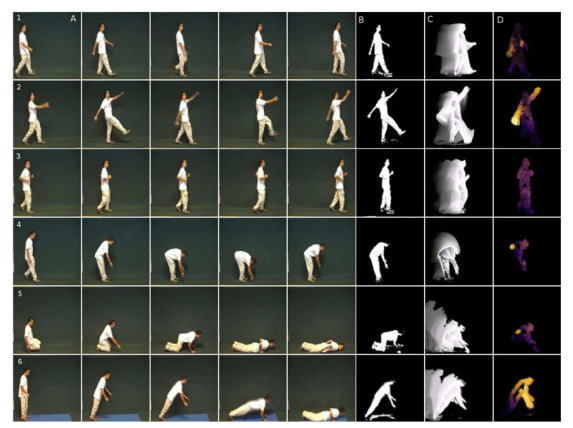

Here are the "motion templates" that are created with optical flow. 


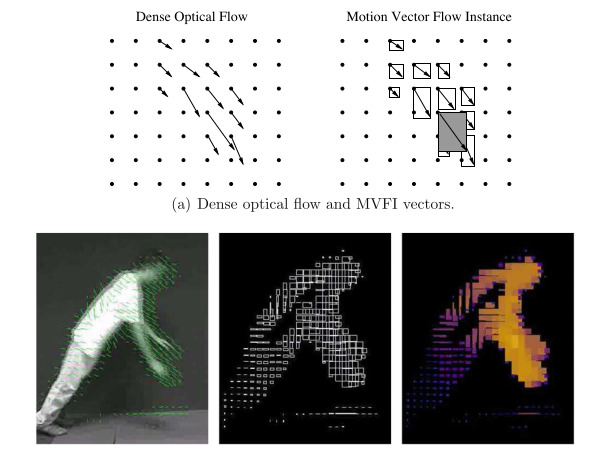

###  Building a Classifier  by projecting into LDA/PCA space

From these templates, we created trajectories in PCA space that are used to classify movements based upon their unique movement templates.   

These are specialized templates that use MVFI.  (Motion Vector Flow Instance).

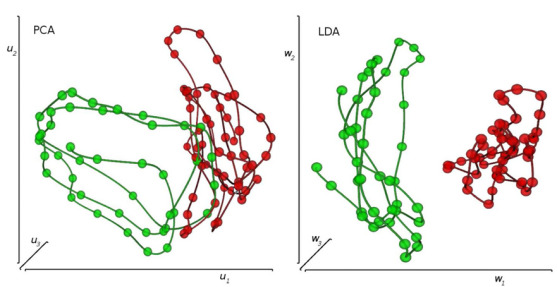

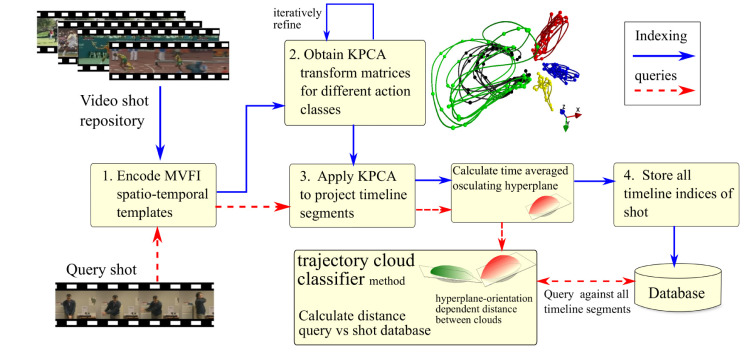